<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/EEG_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and reading the Data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/emotions.csv')
df.columns

Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)

# Visualizing the Signals

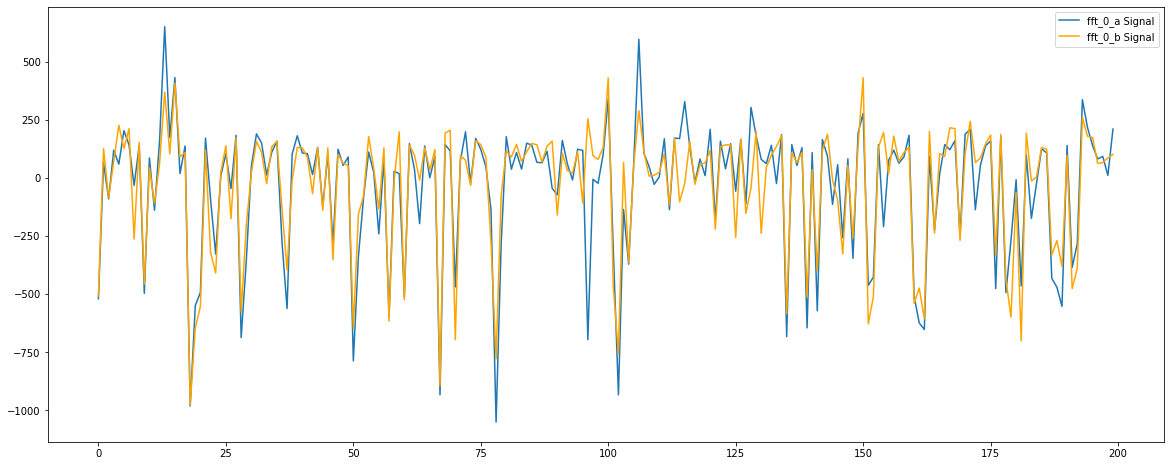

In [5]:
plt.figure(figsize=(20,8))
plt.plot(df['fft_0_a'][:200])
plt.plot(df['fft_0_b'][:200], 'orange')
plt.legend(['fft_0_a Signal', 'fft_0_b Signal'])

# Applying Preprocessing on Data

In [6]:
label_mapping = {'NEGATIVE':0, 'NEUTRAL':1, 'POSITIVE':2}

In [7]:
def preprocess_inputs(dataFrame):
  dataFrame['label'] = dataFrame['label'].replace(label_mapping)
  X = dataFrame.drop('label', axis=1).copy()
  y = dataFrame['label'].copy()
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123)

  return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(32, drop_remainder=True)
dataset = dataset.shuffle(100)
dataset = dataset.repeat()
print(dataset.element_spec)

(TensorSpec(shape=(32, 2548), dtype=tf.float64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))


In [10]:
X_train

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
993,14.400,29.7,-112.0,18.50,22.9,-3.63000,-2.2200,-2.180,-3.240,-4.040,17.700,31.1,-101.0,20.40,27.7,14.700,30.6,-120.0,20.00,22.3,5.45,27.1,-120.0,13.70,19.8,19.500,30.1,-106.0,20.10,21.9,3.020,0.4640,18.900,0.3540,5.38,12.30,3.990,18.90,6.67,7.8200,...,-202.0,174.00,-89.900,-89.900,174.00,148.0,25.00,-29.80,-29.80,25.00,269.000,-103.00,63.50,63.50,-103.00,-71.2,85.60,-61.30,-61.30,85.60,29.8,107.0,-68.40,-68.40,107.0,269.0,28.40,-58.30,-58.30,28.40,-50.0,150.00,-150.00,-150.00,150.00,63.6,83.80,-40.90,-40.90,83.80
1851,13.700,22.8,21.5,8.40,27.1,3.27000,1.1200,6.480,2.300,5.660,13.300,22.2,16.0,7.73,25.8,10.800,22.3,20.4,6.78,22.8,15.20,26.0,20.4,9.75,28.9,15.500,20.8,29.0,9.36,31.0,2.550,-0.0606,-4.470,0.9500,3.00,-1.83,-3.760,-4.40,-2.02,-3.0700,...,178.0,-60.50,-0.106,-0.106,-60.50,124.0,-57.90,26.10,26.10,-57.90,163.000,-36.70,17.90,17.90,-36.70,138.0,-54.70,-66.90,-66.90,-54.70,68.6,-46.5,-58.00,-58.00,-46.5,160.0,-38.90,-3.29,-3.29,-38.90,74.2,-76.00,-10.90,-10.90,-76.00,60.9,-60.40,-31.40,-31.40,-60.40
1253,-0.765,24.7,-578.0,11.90,27.9,-1.44000,-4.2000,-8.310,-4.340,4.040,-0.199,29.3,-580.0,15.10,24.1,0.109,24.5,-569.0,13.10,27.6,1.79,22.6,-559.0,11.10,38.0,-4.680,22.7,-606.0,8.42,22.0,-0.308,4.7800,-11.300,2.0100,-3.48,-1.99,6.680,-21.00,3.99,-13.9000,...,-873.0,653.00,-355.000,-355.000,653.00,-571.0,634.00,-289.00,-289.00,634.00,-41.000,158.00,-50.50,-50.50,158.00,-719.0,566.00,-342.00,-342.00,566.00,-680.0,685.0,-317.00,-317.00,685.0,-112.0,235.00,-71.00,-71.00,235.00,-803.0,619.00,-331.00,-331.00,619.00,-551.0,545.00,-261.00,-261.00,545.00
1228,28.200,32.6,32.1,30.30,24.6,-0.00524,-0.0699,1.680,0.266,-4.470,25.700,33.2,27.5,27.10,30.0,30.600,32.1,34.9,33.10,23.7,28.40,33.8,32.9,30.30,21.1,28.000,31.4,33.0,30.60,23.5,-4.860,1.1300,-7.380,-5.9600,6.26,-2.70,-0.581,-5.35,-3.13,8.8800,...,155.0,-9.87,-28.400,-28.400,-9.87,136.0,2.17,-1.11,-1.11,2.17,48.200,-12.60,53.00,53.00,-12.60,206.0,-4.30,-55.10,-55.10,-4.30,168.0,18.9,-37.20,-37.20,18.9,131.0,9.69,10.90,10.90,9.69,167.0,-24.40,-18.10,-18.10,-24.40,181.0,4.94,-8.33,-8.33,4.94
1461,31.900,31.0,34.4,30.80,24.0,-4.74000,-1.4000,-0.351,-1.830,-5.390,32.700,29.9,34.9,31.80,32.5,35.800,33.4,34.3,31.70,21.0,27.00,32.0,32.3,27.50,23.8,31.900,28.5,36.1,32.30,18.9,-3.170,-3.5500,0.668,0.0455,11.60,5.63,-2.180,2.60,4.31,8.7400,...,131.0,-9.38,-7.340,-7.340,-9.38,126.0,-14.00,41.30,41.30,-14.00,124.000,-13.80,16.70,16.70,-13.80,157.0,-17.10,-7.39,-7.39,-17.10,129.0,-14.5,12.00,12.00,-14.5,112.0,-23.40,41.60,41.60,-23.40,130.0,-25.70,4.10,4.10,-25.70,131.0,-21.70,19.60,19.60,-21.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.820,32.9,-741.0,32.60,27.0,-0.41300,-2.6300,-87.300,-26.200,-3.350,8.190,33.9,-662.0,59.30,34.3,5.890,34.5,-732.0,32.50,23.2,5.86,31.5,-766.0,19.00,23.5,7.350,31.6,-803.0,20.10,27.1,2.300,-0.6200,70.100,26.8000,11.10,2.34,

In [11]:
y_train
num_classes = 3
train_features = X_train.copy()
train_labels = tf.keras.utils.to_categorical(y_train, num_classes)
train_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

# Using Data Generators

In [12]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [13]:
train_batch_size = 32
train_cyclic_generator = get_cyclic_generator(train_features, train_labels, batch_size = train_batch_size)

# Creating Model using the functional API

In [14]:
inputs = tf.keras.layers.Input(shape = (X_train.shape[1],))
expand_dims = tf.expand_dims(inputs, axis = 2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
# dense1 = tf.keras.layers.Dense(10)(flatten)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 2548, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 2548, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 652288)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1956867   
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________


In [233]:
from tensorflow.keras.models import Model
from tensorflow import expand_dims
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, GRU, Bidirectional, Attention, Softmax

# Creating Model using Subclassing API

In [253]:
class MyModel(Model):
  def __init__(self, gru_units, output_units):
    super(MyModel, self).__init__()
    
    # self.inputs = Input(shape = ip_units)
    self.gru = GRU(units=gru_units)
    self.flatten = Flatten()
    self.dense = Dense(output_units, kernel_initializer = 'random_normal')
    self.softmax = Softmax()

  def call(self, inputs):

    # x = self.inputs(inputs)
    x = expand_dims(inputs, axis = 2)
    x = self.gru(x)
    x = self.flatten(x)
    x = self.dense(x)

    return self.softmax(x)


In [254]:
# X_train.shape[1]

model = MyModel(256, 3)
model(tf.random.uniform([1,2548]))

model.summary()

Model: "my_model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 multiple                  198912    
_________________________________________________________________
flatten_34 (Flatten)         multiple                  0         
_________________________________________________________________
dense_34 (Dense)             multiple                  771       
_________________________________________________________________
softmax_30 (Softmax)         multiple                  0         
Total params: 199,683
Trainable params: 199,683
Non-trainable params: 0
_________________________________________________________________


In [255]:
modelSavingPath = 'modelSavingPath/checkpoint_{epoch:02d}'

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.005, patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = modelSavingPath,
    verbose = 1,
    save_weights_only = True,
    save_freq = 'epoch'
)

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [256]:
# history = model.fit(X_train, y_train, batch_size = 32, validation_split = 0.2, epochs = 20, callbacks = [earlyStoppingCallback, checkpoint])
history = model.fit(dataset, steps_per_epoch=X_train.shape[0]//32, epochs = 30, callbacks = [earlyStoppingCallback, checkpoint])

Epoch 1/30
46/46 [==============================] - 6s 103ms/step - loss: 0.5979 - accuracy: 0.7446

Epoch 00001: saving model to modelSavingPath/checkpoint_01
Epoch 2/30
46/46 [==============================] - 5s 101ms/step - loss: 0.3153 - accuracy: 0.8764

Epoch 00002: saving model to modelSavingPath/checkpoint_02
Epoch 3/30
46/46 [==============================] - 5s 106ms/step - loss: 0.2617 - accuracy: 0.8940

Epoch 00003: saving model to modelSavingPath/checkpoint_03
Epoch 4/30
46/46 [==============================] - 5s 106ms/step - loss: 0.2454 - accuracy: 0.9001

Epoch 00004: saving model to modelSavingPath/checkpoint_04
Epoch 5/30
46/46 [==============================] - 5s 103ms/step - loss: 0.2227 - accuracy: 0.9185

Epoch 00005: saving model to modelSavingPath/checkpoint_05
Epoch 6/30
46/46 [==============================] - 5s 101ms/step - loss: 0.2134 - accuracy: 0.9151

Epoch 00006: saving model to modelSavingPath/checkpoint_06
Epoch 7/30
46/46 [======================

In [251]:
train_steps_per_epoch = len(X_train) // train_batch_size

# history = model.fit_generator(generator=train_generator_cyclic, callbacks=[earlyStoppingCallback, checkpoint], steps_per_epoch=train_steps_per_epoch, epochs=50)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history2 = model.fit(train_cyclic_generator, steps_per_epoch=train_steps_per_epoch, epochs=500)
# next(train_cyclic_generator)

AttributeError: ignored

# Traing Accuracy and Loss vs Time

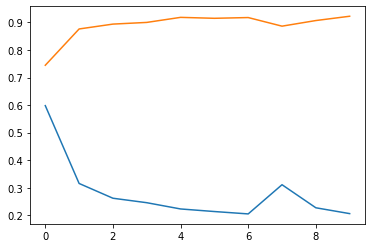

In [257]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

# print(history.history)

# Evaluating Model performance

In [258]:
modelPerformance = model.evaluate(X_test, y_test, verbose = 1)

20/20 [==============================] - 1s 49ms/step - loss: 0.2278 - accuracy: 0.9047


In [259]:
modelAcc = modelPerformance[1]
print("Test Accuracy: {:0.3f}%".format(modelAcc*100))

Test Accuracy: 90.469%
